# Task 2 Закрепление Линейной Регрессии 
#  (Продвинутый канал)

**Задание:**

1. Ознакомьтесь с содержанием демонстрационных блокнотов (Неделя 3 и аналог для синтетических данных) 

2. Создайте новый блокнот, импортируйте необходимые библиотеки (не обязательно копировать все - только нужные функции и /или классы)

3.  Для синтетических данных 

3.1 Сгенерируйте различные линейные, полиномиальные и другие зависимости отличные от тех, что в примере(как минимум 3 поднабора)

3.2 Проверьте как с этими наборами справятся полиномы различной степени и разные типы регуляризации

4. Скачайте набор данных Cars Moldova (можно сразу очищенных от дубликатов и выбросов, лучше с добавленными признаками из "Закрепления Исследовательского анализа")  

4.1 Используйте любую из подготовленных вами моделей линейной регрессии для предсказания цены автомобилей на вторичном рынке Молдавии. Оцените модель на отложенной выборке  
4.2 Оцените влияние разных типов предварительной обработки на результат  
4.3 Сравните результаты модели при использовании только числовых признаков и при добавлении категориальных признаков с помощью one-hot кодирования  
4.4 Оцените наиболее значимые признаки для модели проанализировав веса  

5. Загрузите ссылку (предварительно убедившись в открытом доступе) или ipynb файл своего решения в MS Teams 

Блокнот необходимо прилежно оформить  

хочется видеть структуру (Заголовки разного уровня);  
ожидается видеть не только код, но и комментарии к нему;  
не должно быть запущенных ячеек с ошибками; 
ожидается что рисунки адекватно оформлены (не маленького размера, есть описание того, что на рисунке)

In [1]:
"-"*50

'--------------------------------------------------'

### Загрузка библиотек

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 3.1 Сгенерируйте различные линейные, полиномиальные и другие зависимости отличные от тех, что в примере(как минимум 3 поднабора)

**Генерация Данных**

In [3]:
def true_fun(x, a=np.pi, b = 0, f=np.sin):
    x = np.atleast_1d(x)[:]
    a = np.atleast_1d(a)
    
    if f is None: f = lambda x:x # line
    x = np.sum([ai*np.power(x, i+1) for i,ai in enumerate(a)],axis=0)

    return f(x+ b)

def noises(shape , noise_power):
    return np.random.randn(*shape) *noise_power

def dataset(a, b, f = None,  N = 250, x_max =1, noise_power = 0, random_x = True,  seed = 42):
    np.random.seed(seed)
    
    if random_x:
        x = np.sort(np.random.rand(N))*x_max    
    else:
        x = np.linspace(0,x_max,N)
    
    y_true = np.array([])
    
    for f_ in np.append([], f):
        y_true=np.append(y_true, true_fun(x, a, b, f_))
    
    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape , noise_power)

    return y, y_true, np.atleast_2d(x).T

In [4]:
def vis_data(y, y_true,x, title):
    fig  = plt.figure(figsize=(15,10))
    plt.scatter(x[:,0], y, edgecolor='b', label="Зашумленные Данные",s=196, alpha = 0.6)
    plt.scatter(x[:,0], y_true,label="Реальные Данные", s=81,c='g', alpha = 0.8)
    plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35)
    plt.legend(fontsize=25)
    plt.title(title, fontsize=25 )
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);
    plt.tight_layout()

In [5]:
noise_power = 0.1
y, y_true, x = dataset(a = 2, b = 2,
                       f = None,  N = 100,
                       x_max =1, 
                       noise_power = noise_power,
                       seed = 42)

**Функции (все)**

In [6]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

In [7]:
def train_test_split(x,y, train_size=None, test_size=None, random_state=42, shuffle=True,):
    if random_state: np.random.seed(random_state)
    
    size = y.shape[0]
    idxs = np.arange(size)
    if shuffle: np.random.shuffle(idxs)
    
    if test_size and train_size is None:
        if (test_size<= 1):  train_size = 1 - test_size
        else:  train_size = size - test_size
        test_size = None    
        
    if train_size is None or train_size > size: train_size = size
        
    if (train_size<= 1): train_size *= size
        
    if test_size is not None: 
        if test_size<= 1: test_size *= size    
        if test_size>size: test_size = size-train_size
    else: test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val,   y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]
    
    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, y_train.squeeze(), x_val, y_val.squeeze(), x_test, y_test.squeeze() 
    return x_train, y_train.squeeze(), x_val, y_val.squeeze()


x_train, y_train, x_val, y_val, x_test, y_test = train_test_split(x, y, train_size = 0.5, test_size=0.3, )    
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    

In [8]:
def init_weights(W_shape, add_bias = True, random_state = 42):
    W_shape = np.atleast_1d(W_shape)
    if random_state: 
        np.random.seed(random_state)
    W = np.random.randn(*list(W_shape))/np.sqrt(np.sum(W_shape))    
    if add_bias: 
        W = np.column_stack((np.zeros(W.shape[-1]),W ))
    return W.squeeze()

In [9]:
def predict( X, W, add_bias = True):
    if add_bias:
        X_full = np.column_stack((np.ones(X.shape[0]),X))
    else:
        X_full = X
    return  np.dot(X_full,W)

def loss_func(yhat, y):
    return np.square(yhat - y)  

In [10]:
def update_weights(grad, W, learning_rate):
    return W - learning_rate*grad

In [11]:
def grad_loss(y_hat, y, X, add_bias = True):
    if add_bias:
        X_full = np.column_stack((np.ones(X.shape[0]),X))
    else:
        X_full = X
    return 2*np.dot(X_full.T, (y_hat - y)) / y.size  

In [12]:
def grad_loss(y_hat, y, X, add_bias = True):
    if add_bias:
        X_full = np.column_stack((np.ones(X.shape[0]),X))
    else:
        X_full = X
    return 2*np.dot(X_full.T, (y_hat - y)) / y.size  

In [13]:
def fit(X, y, learning_rate, weights = None,  epochs=30):

    if weights is None: weights = init_weights(X.shape[1])
    cost    = np.zeros(epochs)

    for i in range(epochs): 
        yhat    = predict(X,weights)
        grad    = grad_loss(yhat,  y, X) 
        weights = update_weights(grad, weights, lerning_rate)  
        cost[i] = loss_func(yhat,  y).mean()
                
    return weights, cost

In [14]:
def plot_cost(cost):
    plt.plot(cost, 'o-', linewidth = 4, markersize = 15); 
    plt.grid()
    plt.xlabel("Эпоха",fontsize=35)
    plt.ylabel("Функция Потерь",fontsize=35)
    plt.xticks(FontSize = 25)

    plt.yticks(FontSize = 25);  

In [15]:
def r2_score(yhat, y):    
    return 1-(np.square(y-yhat)).sum(axis=0)/(np.square(y-np.mean(y, axis=0))).sum(axis=0)

In [16]:
def load_batch(X,y, batch_size = 100):
    idxs = np.arange(y.size)
    np.random.shuffle(idxs)

    for i_batch in range(0,y.size,batch_size):
        idx_batch = idxs[i_batch:i_batch+batch_size]
        x_batch   = np.take(X, idx_batch,axis=0)
        y_batch   = np.take(y, idx_batch)
        yield  x_batch, y_batch

In [17]:
BATCH = 10

def fit_SGD(X, y, lerning_rate, weights = None,  epochs=30, batch_size = 100, random_state = 42):
    
    if random_state: np.random.seed(random_state)

    if weights is None: weights = init_weights(X.shape[1])
    if batch_size is None or batch_size>y.size : batch_size = y.size
    n_batches = y.size//batch_size
    
    cost    = np.zeros(epochs)

    for i in range(epochs): 
        loss = 0
        for cnt,(x_batch, y_batch) in enumerate(load_batch(X,y, batch_size)): 

            yhat    = predict(x_batch, weights)
            grad    = grad_loss(yhat,  y_batch, x_batch) 
            weights = update_weights(grad, weights, lerning_rate) #backward 
            loss   += loss_func(yhat,  y_batch).mean()

            if cnt>= n_batches:
                break
        cost[i] = loss/n_batches

    return weights, cost

In [18]:
def plot_model_weights(x_train, y_train, x_test, x, y, weights):
    plt.plot(x_train[:,0], predict(x_train,weights, ),
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], predict(x_test,weights, ),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth=4,c='g')
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35);
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);

In [19]:
def to_polynom(x, order = 1, add_bias = False):
    order_range = range( 0 if add_bias else 1, order+1,1)
    x = np.atleast_1d(x)[:]    
    out = np.array([])
    for i in order_range:
        out = np.append(out, np.power(x,i))
    return out.reshape(-1, x.size).T

In [20]:
def plot_model_class(x_train, y_train, x_test, x, y, model):
    plt.plot(x_train[:,0], model.predict(x_train),
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], model.predict(x_test),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth=4,c='g')
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35);
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);

СТОП!!!

**Линейная зависимость**

*Поднаборы зависимостей*

In [21]:
noise_power = [0.1,0.2,0.3]
A = [1,2,3]
B = [2,4,6]
n = [100,150,200]
lerning_rate = 0.1

In [22]:
def lin(i):
    y, y_true, x = dataset(a = A[i], b = B[i],
                        f = None,  N = n[i],
                        x_max =1, 
                        noise_power = noise_power[i],
                        seed = 42)
    x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
    weights = init_weights(x.shape[1])
    yhat = predict( x_train[0],weights)
    loss = loss_func(yhat, y[0])
    yhat = predict(x_train[0], weights)
    grad = grad_loss(yhat, y[0], x[0])
    lerning_rate = 0.1
    weights = update_weights(grad, weights, lerning_rate)
    yhat = predict( x_train[0],weights)
    loss = loss_func(yhat, y[0])
    weights, cost = fit(x_train, y_train, learning_rate=0.1, epochs=10)
    fig  = plt.figure(figsize=(14,8))
    plot_cost(cost)
    predicts = predict( x_test,weights,)
    r2_score(predicts, y_test), r2_score(predict(x_train,weights, ), y_train)
    fig  = plt.figure(figsize=(14,8))
    plot_model_weights(x_train, y_train, x_test, x, y_true, weights)
    weights = init_weights(x_train.shape[1], random_state=42)
    weights, cost = fit_SGD(x_train, y_train, lerning_rate=0.1, batch_size = 10,  epochs=10)
    predicts = predict(x_test, weights, )
    r2_score(predicts, y_test), r2_score(predict(x_train,weights, ), y_train)
    fig  = plt.figure(figsize=(14,8))
    plot_cost(cost)
    fig  = plt.figure(figsize=(14,8))
    plot_model_weights(x_train, y_train, x_test, x, y_true, weights)

<ipython-input-14-8d749284a1c4>:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(FontSize = 25)
<ipython-input-14-8d749284a1c4>:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(FontSize = 25);
<ipython-input-18-a33491cfb7e3>:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(FontSize = 25)
<ipython-input-18-a33491cfb7e3>:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(FontSize = 25);
<ipython-input-14-8d749284a1c4>:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(FontSize = 25)
<ipython-in

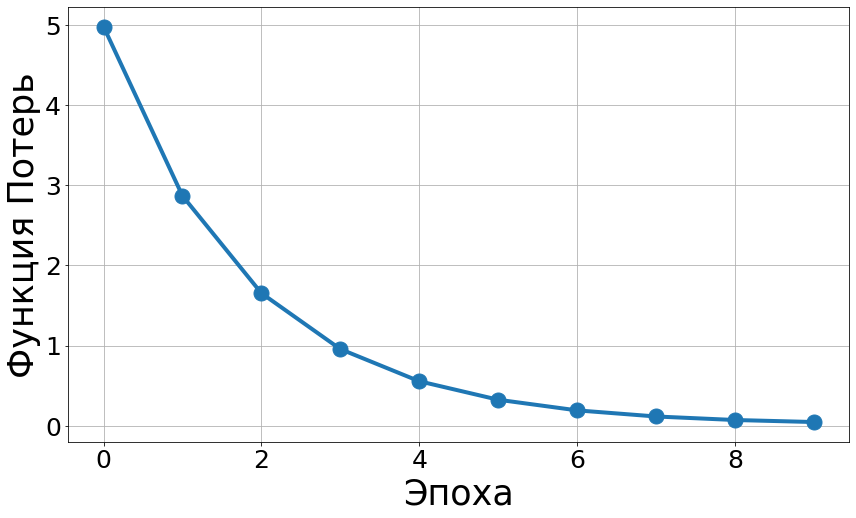

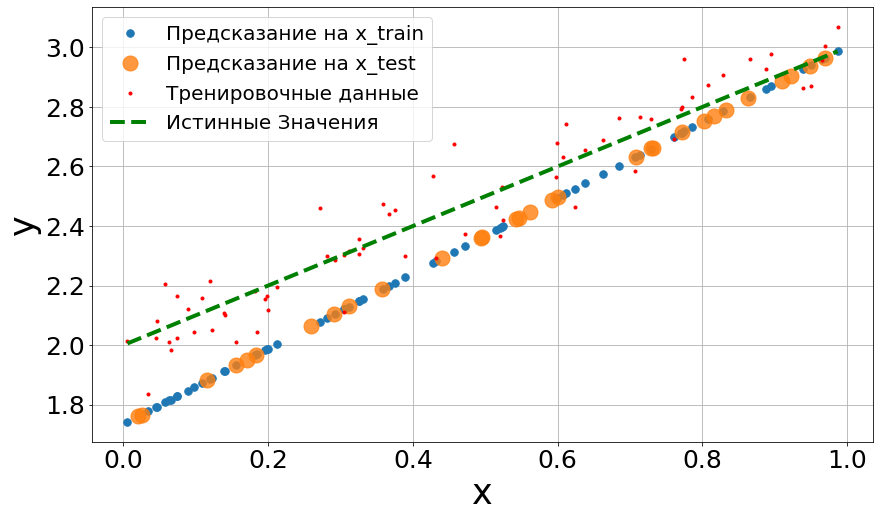

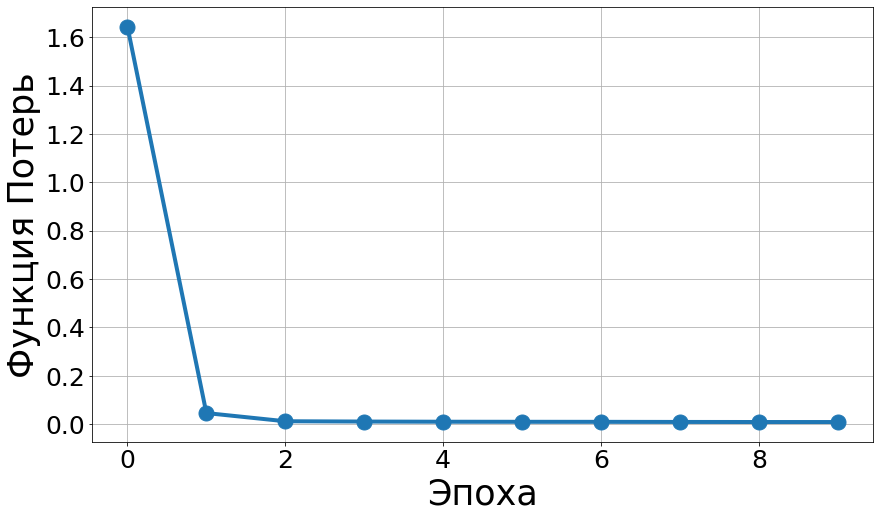

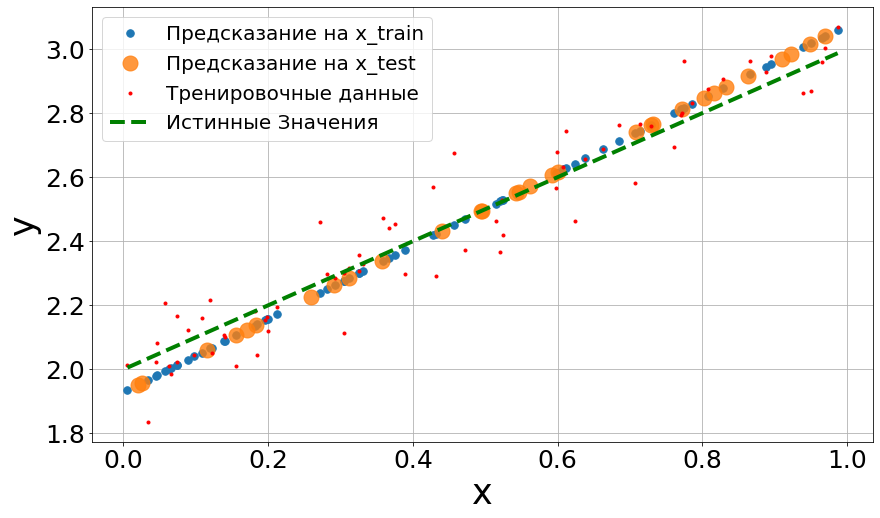

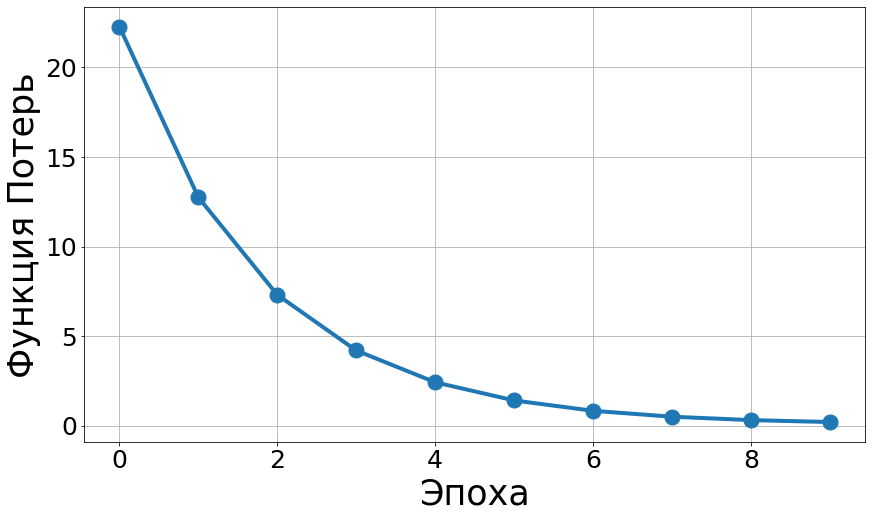

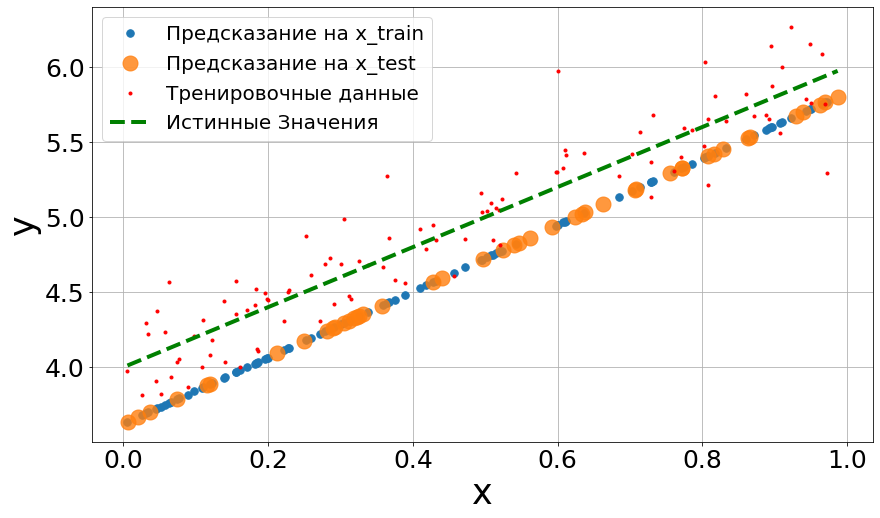

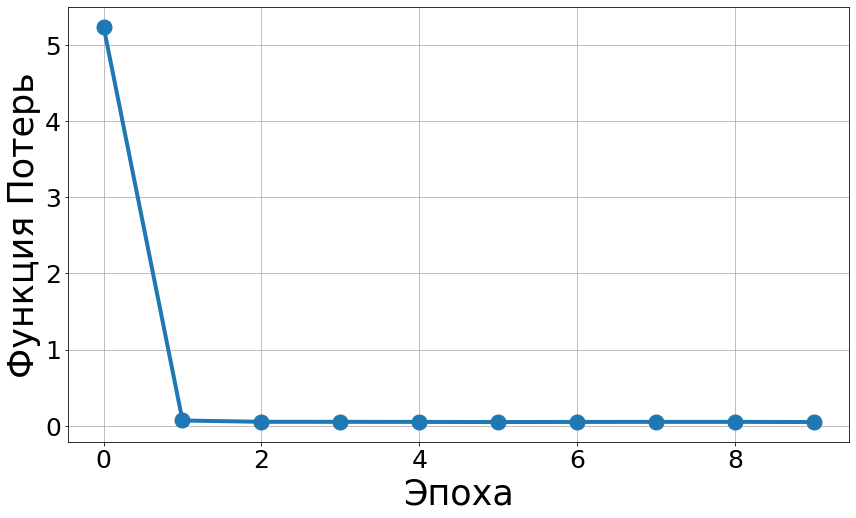

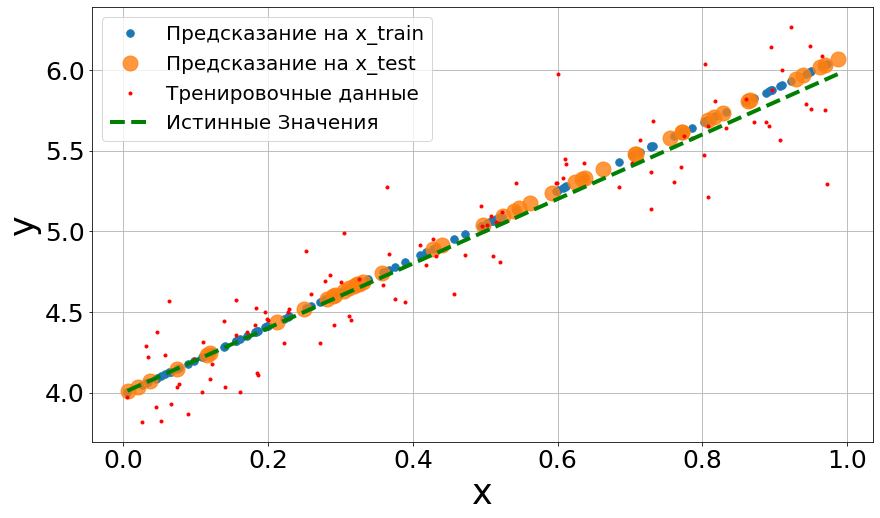

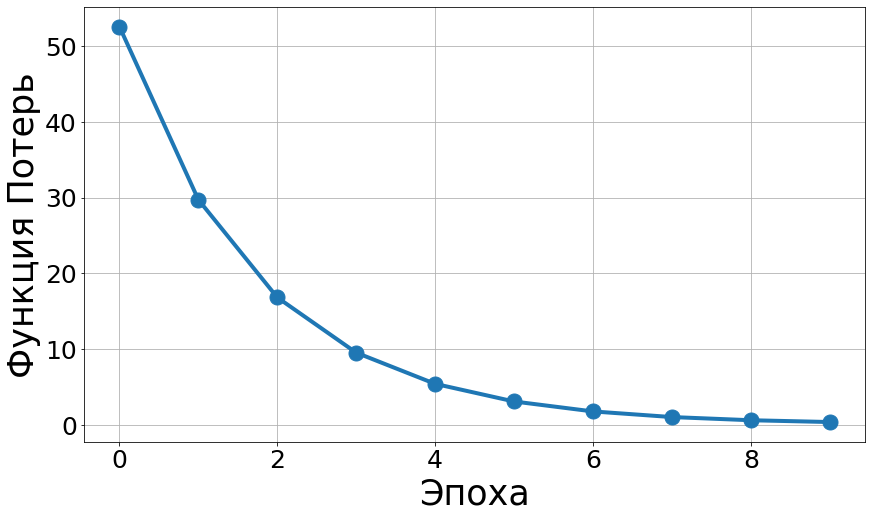

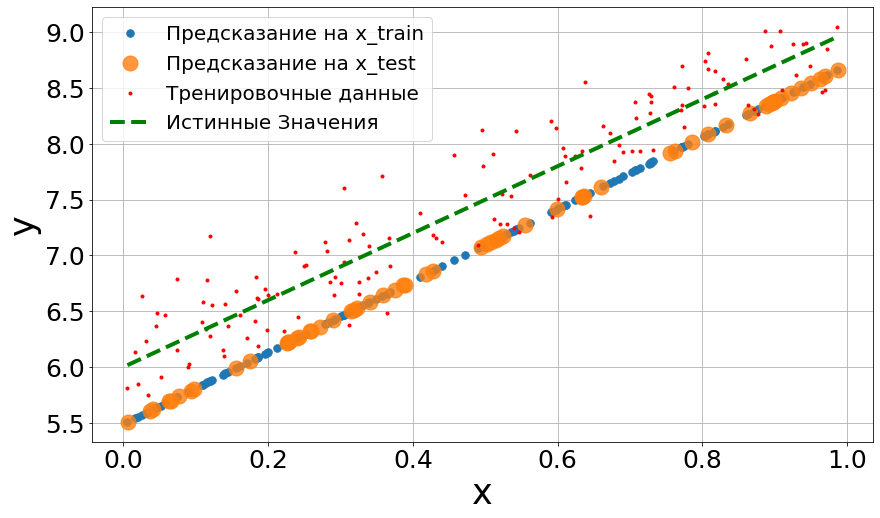

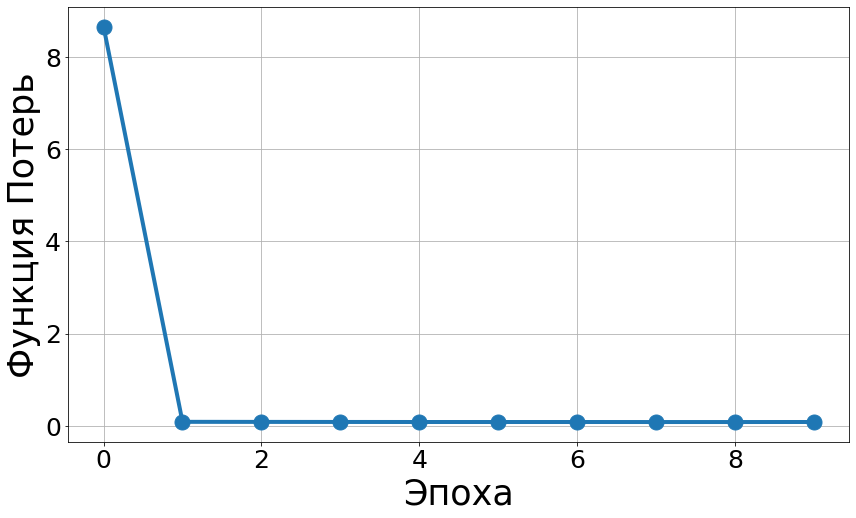

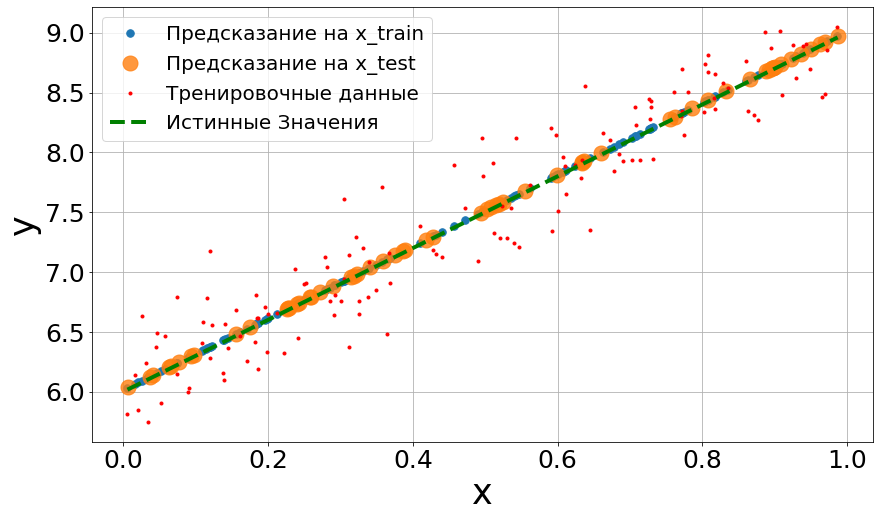

In [23]:
for el in range(3):
    lin(el)

**Полиномальная Зависимость**

In [24]:
noise_power = [0.1,0.2,0.3]
A = [[1,2,-2],[1,5,-3],[4,10,-7]]
B = [-1,-2,-3]
n = [200,250,300]

In [25]:
def poly(i):
    y, y_true, x = dataset(a = A[i], b = B[i],
                           f = None,  N = n[i],
                           x_max =1.25, 
                           noise_power = noise_power[i],
                           seed = 42)
    vis_data(y, y_true,x, 'Полиномиальная зависимость')
    x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
    regr_poly_lin = LinearRegression(learning_rate=0.1,
                            epochs=10,batch_size=10,
                            n_batches=None)
    regr_poly_lin.fit(x_train, y_train)
    fig  = plt.figure(figsize=(14,8))

    plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly_lin)

<ipython-input-4-d99cf6dd878c>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(FontSize = 25)
<ipython-input-4-d99cf6dd878c>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(FontSize = 25);
<ipython-input-20-3d6b60ba2fa6>:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(FontSize = 25)
<ipython-input-20-3d6b60ba2fa6>:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(FontSize = 25);
<ipython-input-4-d99cf6dd878c>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(FontSize = 25)
<ipython-in

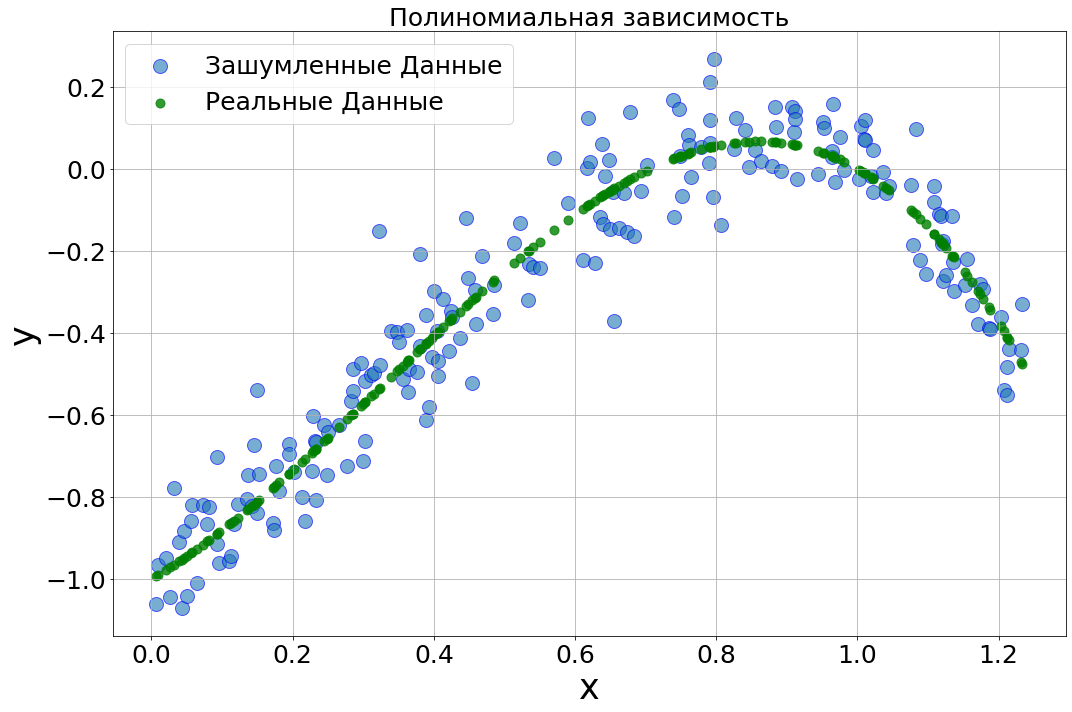

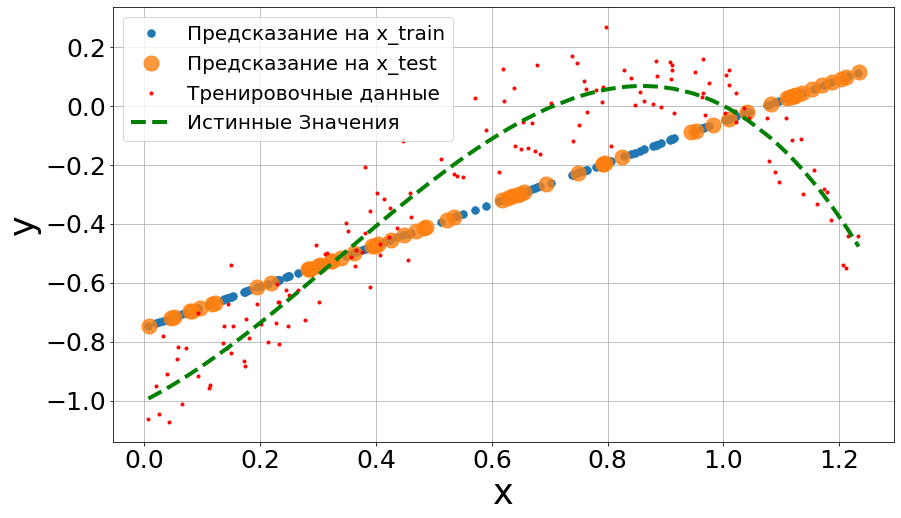

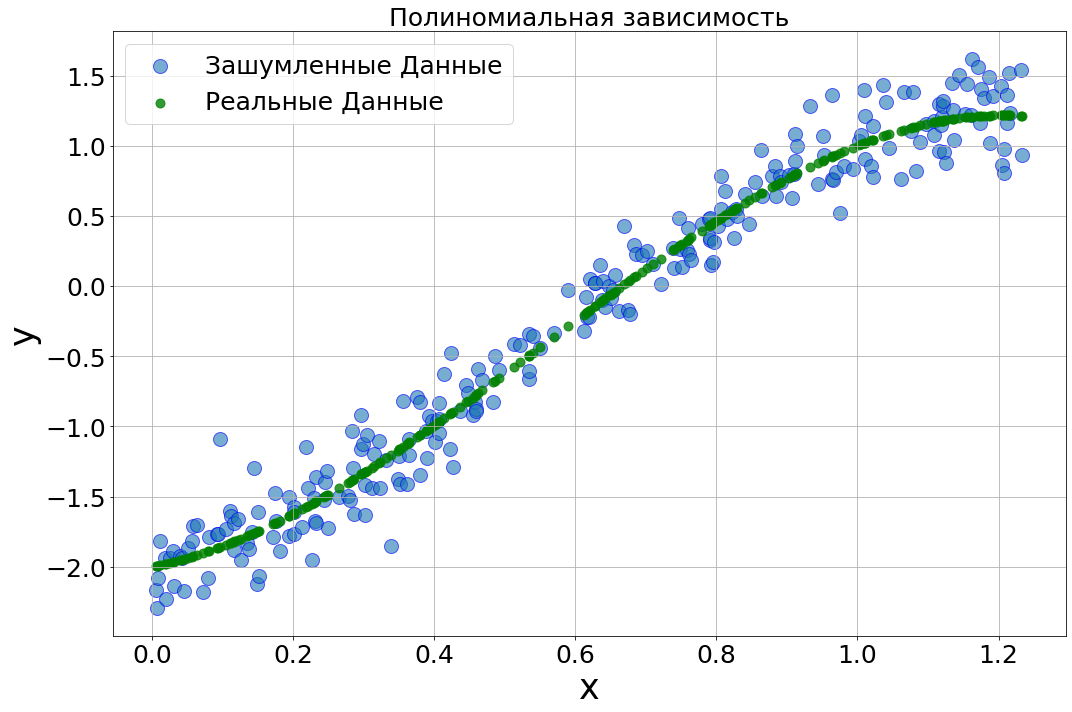

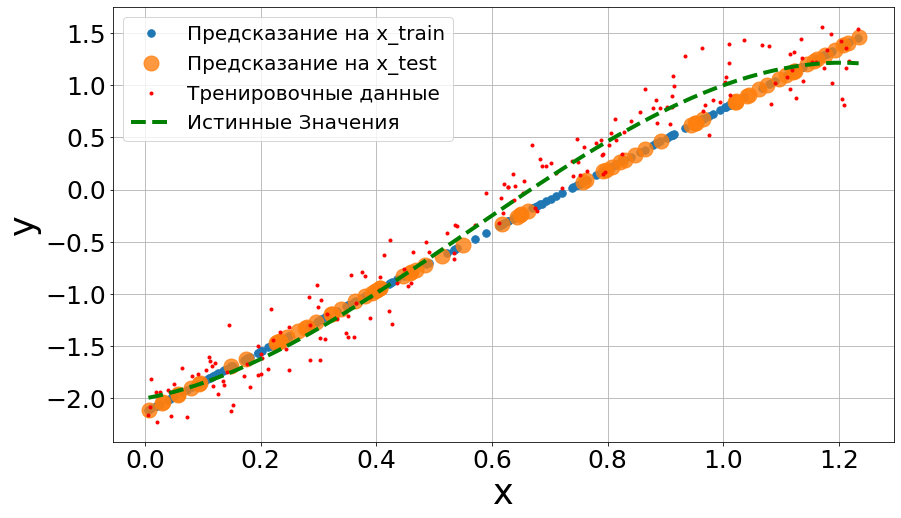

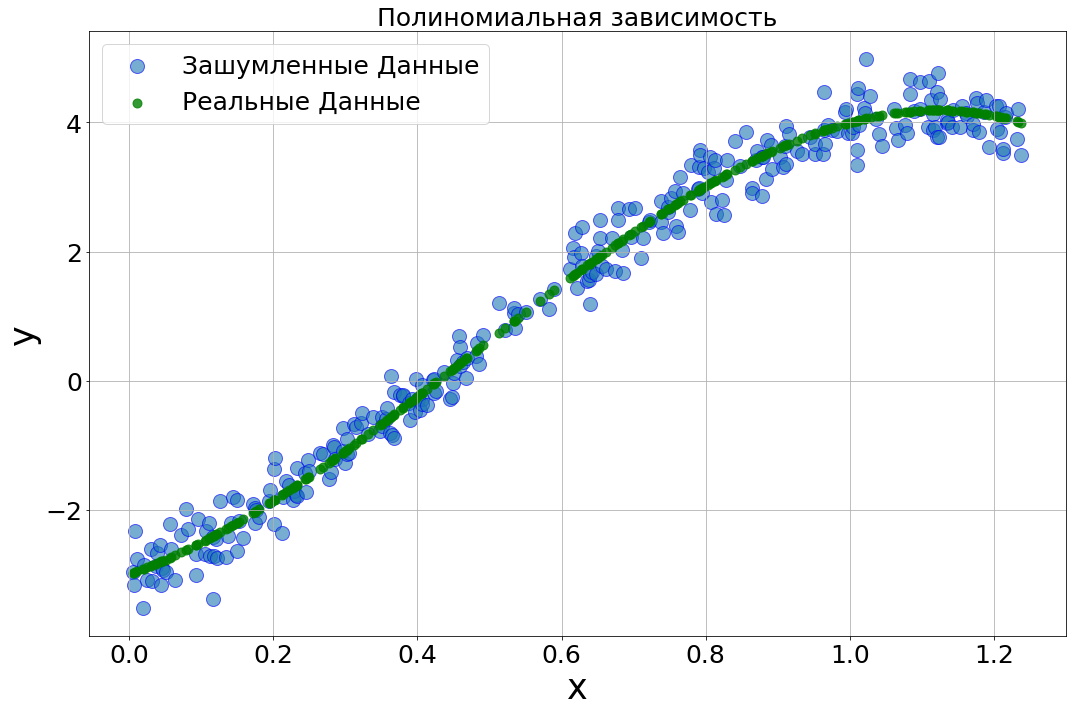

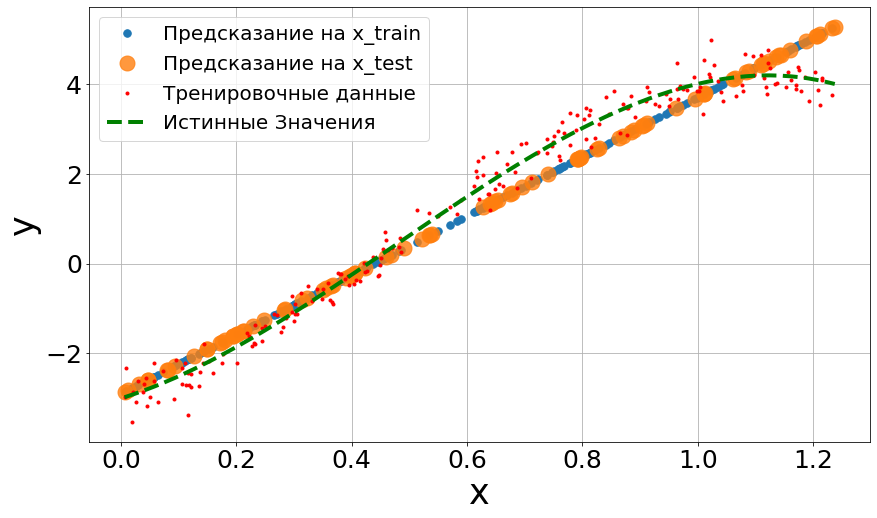

In [26]:
for el in range(3):
    poly(el)

**Гармоническая зависимость**

In [27]:
noise_power = [0.1,0.2,0.3]
A = [1,2,3]
B = [np.cos,np.sin,np.tan]
n = [4,6,8]

In [28]:
def garm(i):
    y, y_true, x = dataset(a = A[i]*np.pi,
                           b = np.pi, f = B[i],  
                           N = 50, x_max =np.pi/n[i], 
                           noise_power = noise_power[i], seed = 42)
    vis_data(y, y_true,x, 'Гармоническая зависимость')
    x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, ) 
    regr_harm = LinearRegression(learning_rate=0.25,
                        epochs=100,batch_size=10,
                        n_batches=None)
    regr_harm.fit(x_train, y_train)

    print(f'Train Score = {regr_harm.score(x_train, y_train):.2f}')
    regr_harm.plot_cost()
    fig  = plt.figure(figsize=(14,8))
    plot_model_class(x_train, y_train, x_test, x, y_true, regr_harm)

<ipython-input-4-d99cf6dd878c>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(FontSize = 25)
<ipython-input-4-d99cf6dd878c>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(FontSize = 25);


Train Score = 0.96


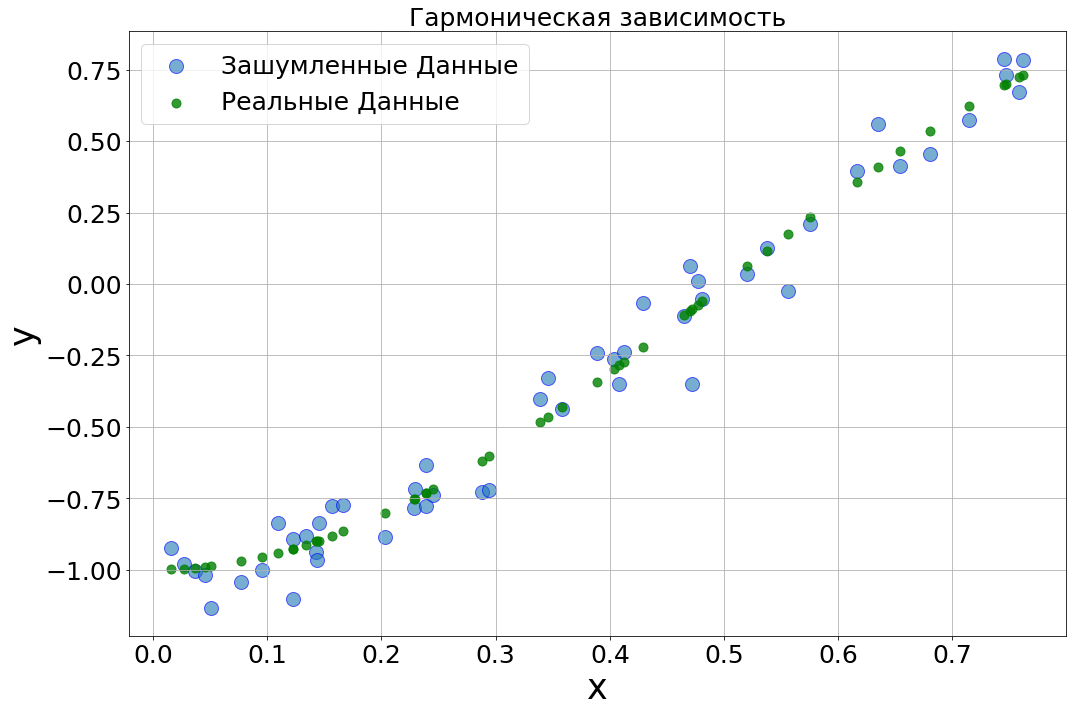

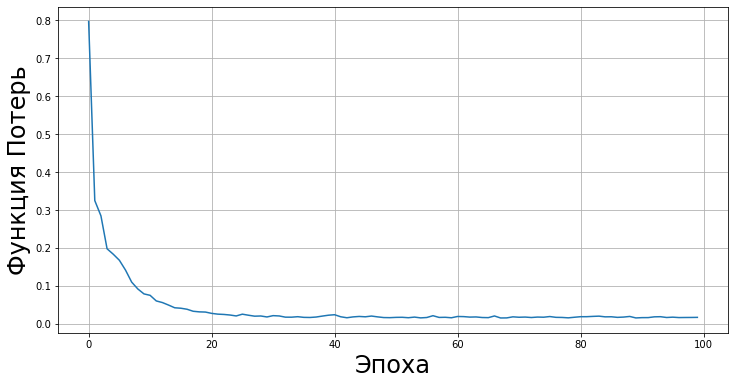

<ipython-input-20-3d6b60ba2fa6>:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(FontSize = 25)
<ipython-input-20-3d6b60ba2fa6>:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(FontSize = 25);
<ipython-input-4-d99cf6dd878c>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(FontSize = 25)
<ipython-input-4-d99cf6dd878c>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(FontSize = 25);


Train Score = -0.02


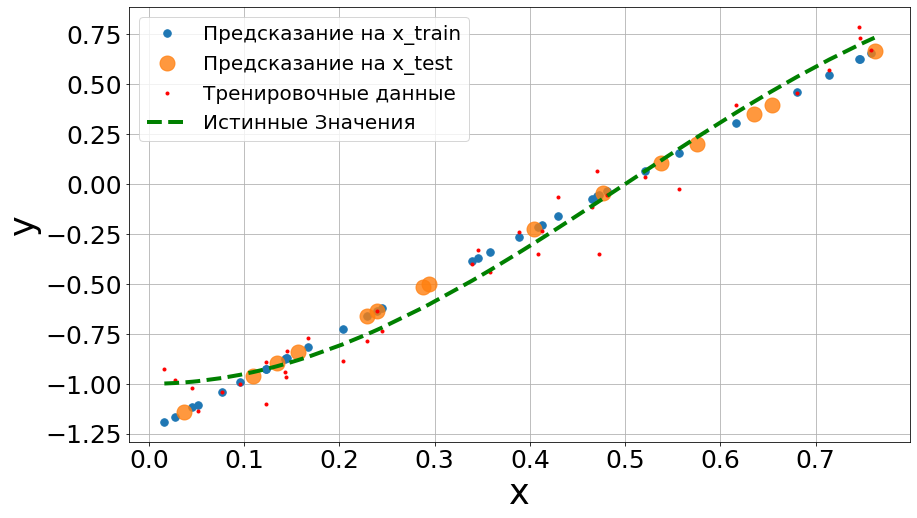

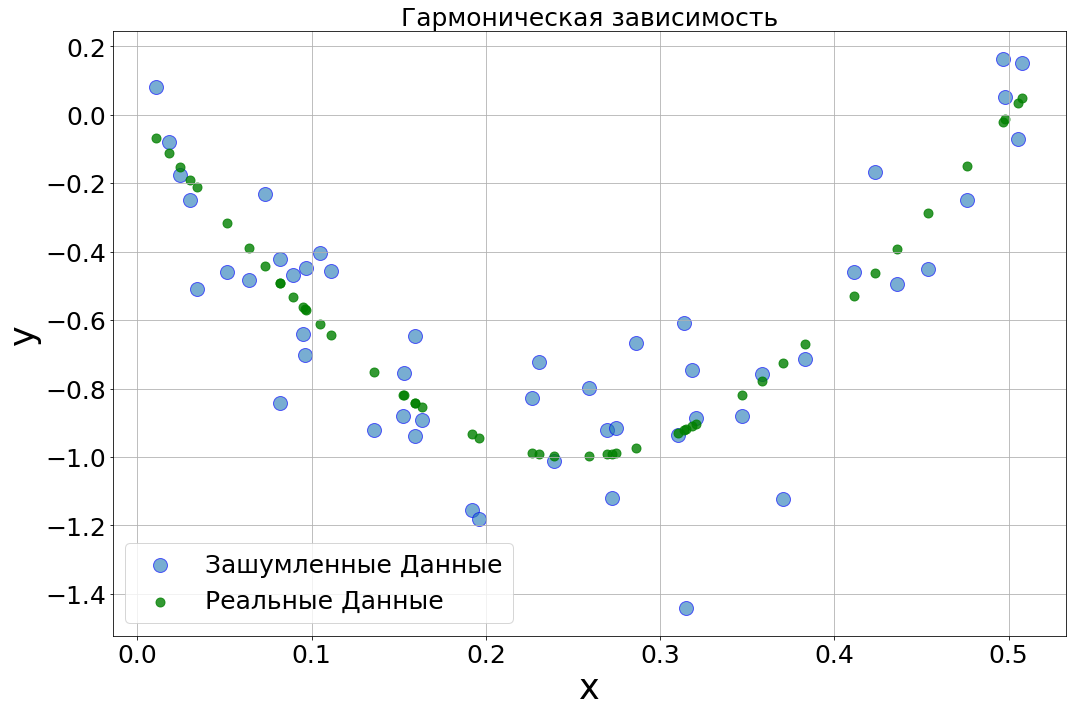

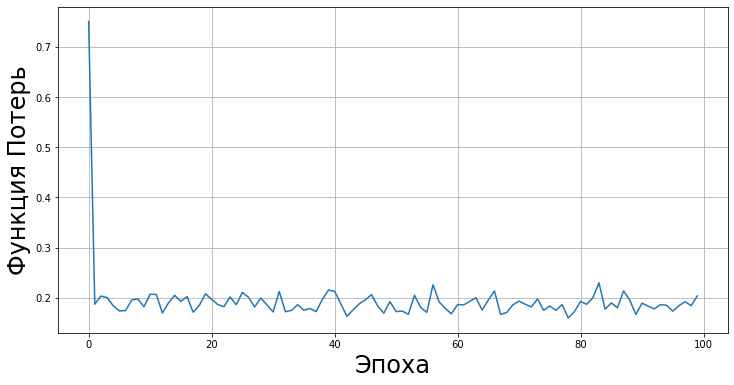

<ipython-input-20-3d6b60ba2fa6>:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(FontSize = 25)
<ipython-input-20-3d6b60ba2fa6>:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(FontSize = 25);
<ipython-input-4-d99cf6dd878c>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(FontSize = 25)
<ipython-input-4-d99cf6dd878c>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(FontSize = 25);


Train Score = 0.00


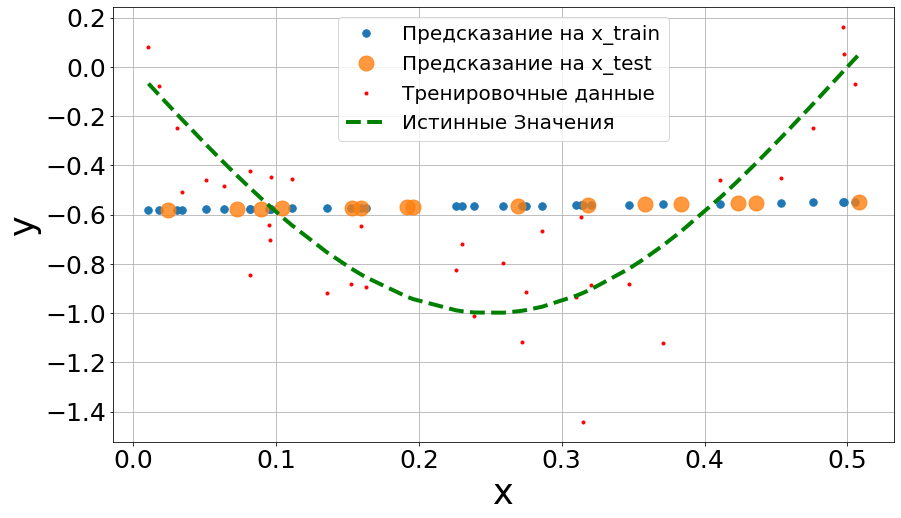

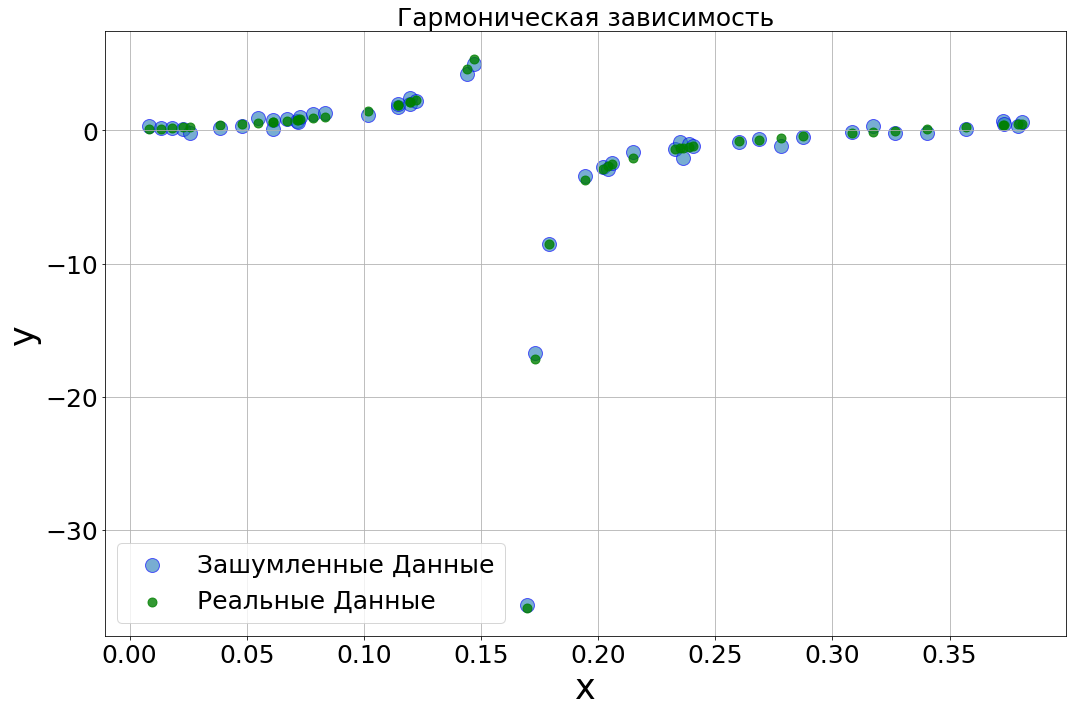

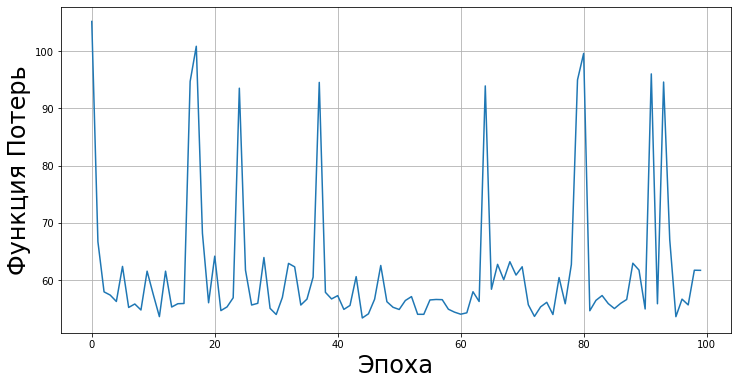

<ipython-input-20-3d6b60ba2fa6>:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(FontSize = 25)
<ipython-input-20-3d6b60ba2fa6>:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(FontSize = 25);


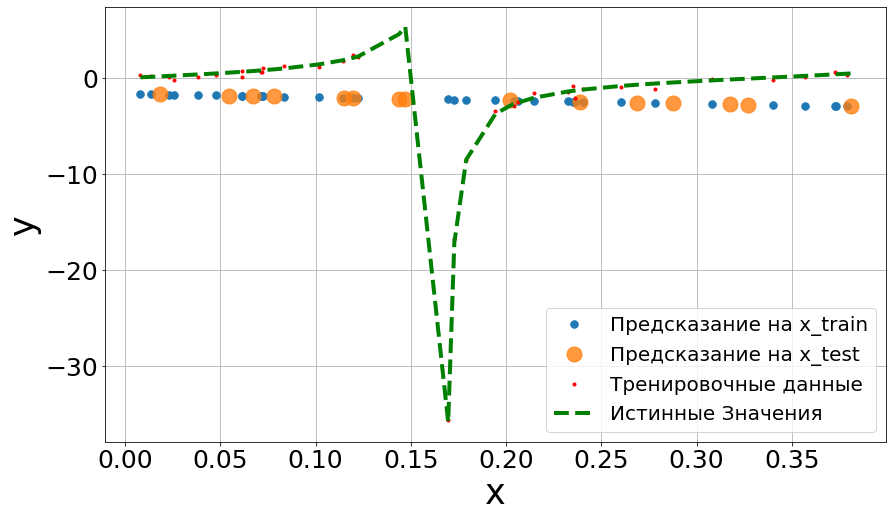

In [29]:
for el in range(3):
    garm(el)